# Lecture 6

The primary **objective** of this lecture is to combine the spatial data frames from Lecture 5 with some very basic clustering algorithms and simulations (specifically, permutation tests).

The secondary objective is to examine whether state-level policy has an appreciable impact on the composition of farmers’ markets in the Southwest. As in a previous section, we’ll pull [data on 7,863 farmers’ markets in the United States from USDA](https://www.ams.usda.gov/local-food-directories/farmersmarkets). I have exported and saved the data as a CSV to the main branch of the github repository, which you can read directly into a DataFrame.

In [3]:
import pandas
import geopandas
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

df = pandas.read_csv(
    "https://raw.githubusercontent.com/ds-modules/DATA88-SP22/main/Lecture6/farmers-mkts.csv",
    dtype={"FMID": str}
)

Next let's plot the data and look for anomalies. First, read in the boundaries for the United States, and then restrict geography to the continental United States (CONUS).  We can read the boundaries directly from the file we used in Lecture 5.

In [4]:
usa = geopandas.read_file("https://raw.githubusercontent.com/ds-modules/DATA88-SP22/main/Lecture5/gz_2010_us_040_00_20m.geojson")

conus_names = {
    'AL': 'Alabama',
    'AR': 'Arkansas',
    'AZ': 'Arizona',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DC': 'District of Columbia',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'IA': 'Iowa',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'MA': 'Massachusetts',
    'MD': 'Maryland',
    'ME': 'Maine',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MO': 'Missouri',
    'MS': 'Mississippi',
    'MT': 'Montana',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'NE': 'Nebraska',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NV': 'Nevada',
    'NY': 'New York',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VA': 'Virginia',
    'VT': 'Vermont',
    'WA': 'Washington',
    'WI': 'Wisconsin',
    'WV': 'West Virginia',
    'WY': 'Wyoming'
}

conus = usa[usa.NAME.isin(list(conus_names.values()))]

In [5]:
# Drop any observations with missing values for critical fields
mkt_loc = df[["FMID", "x", "y", "State"]].dropna()

# filter the markets
conus_state_names = list(conus_names.values())
mkt_loc = mkt_loc[mkt_loc.State.isin(conus_state_names)]

# create a geopandas dataframe from the standard pandas dataframe
mkt_loc_gdf = geopandas.GeoDataFrame(
    mkt_loc, 
    geometry=geopandas.points_from_xy(mkt_loc.x, mkt_loc.y)
)

# preview the new geodataframe
mkt_loc_gdf

,FMID,x,y,State,geometry
0,1002267,-76.135361,36.841885,Virginia,POINT (-76.13536 36.84188)
1,21005876,-84.768900,33.719600,Georgia,POINT (-84.76890 33.71960)
2,1001666,-85.575020,42.295960,Michigan,POINT (-85.57502 42.29596)
3,21002563,-73.949300,40.793900,New York,POINT (-73.94930 40.79390)
4,1003680,-75.534267,39.741993,Delaware,POINT (-75.53427 39.74199)
...,...,...,...,...,...
7859,22003665,-75.618400,40.321600,Pennsylvania,POINT (-75.61840 40.32160)
7860,1001676,-93.590061,45.443389,Minnesota,POINT (-93.59006 45.44339)
7861,1001556,-113.003000,37.184200,Utah,POINT (-113.00300 37.18420)
7862,22003298,-86.261200,39.949100,Indiana,POINT (-86.26120 39.94910)


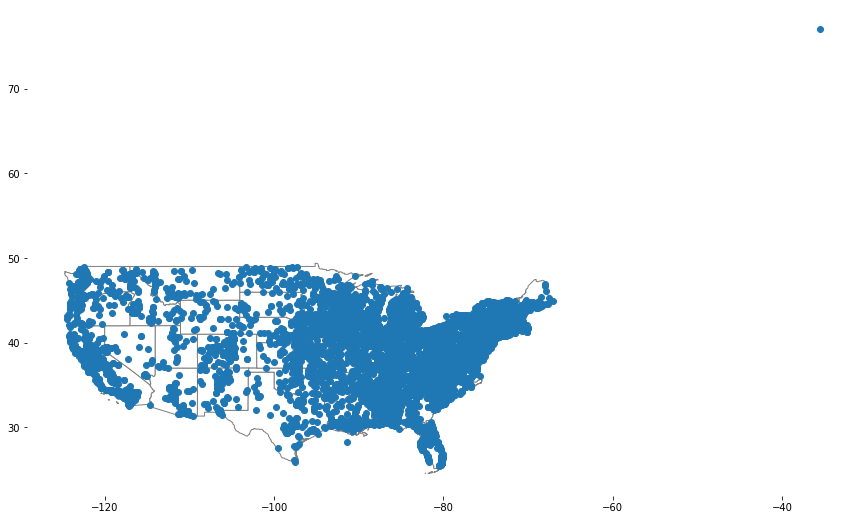

In [6]:
# plot the farmers' markets on top of the CONUS state boundaries
fig, ax = plt.subplots(figsize=(18,9))

conus.plot(
    ax=ax,
    color='white', 
    edgecolor='grey'
)

mkt_loc_gdf.plot(ax=ax)

plt.box(on=None) 

# There is an outlier. Something's wrong.

In [7]:
# Knock out the bad observation
mkt_loc_gdf = mkt_loc_gdf[mkt_loc_gdf.x < -60]

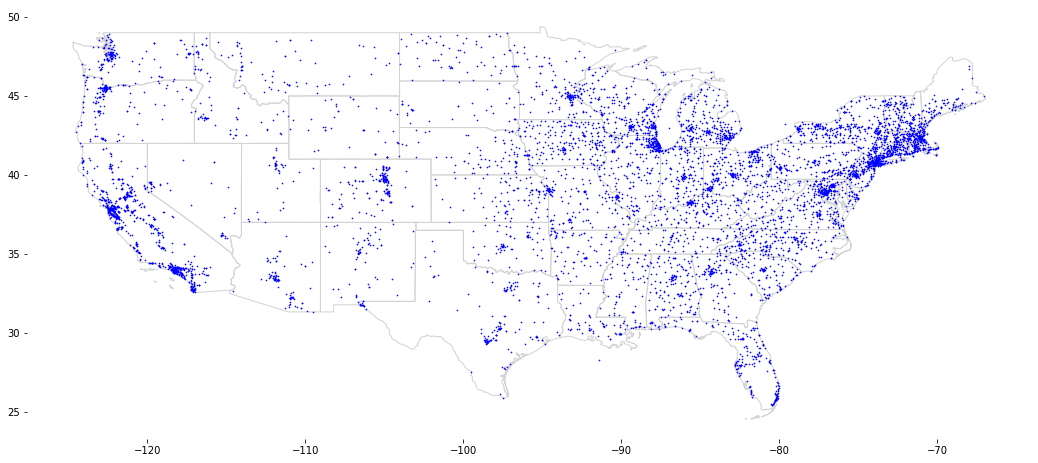

In [8]:
# Plot the farmers' markets on top of the CONUS state boundaries
fig, ax = plt.subplots(figsize=(18,9))

conus.plot(
    ax=ax,
    color='none', 
    edgecolor='lightgrey'
)

mkt_loc_gdf.plot(
    ax=ax,
    markersize=0.4,
    color="blue"
)

plt.box(on=None) 

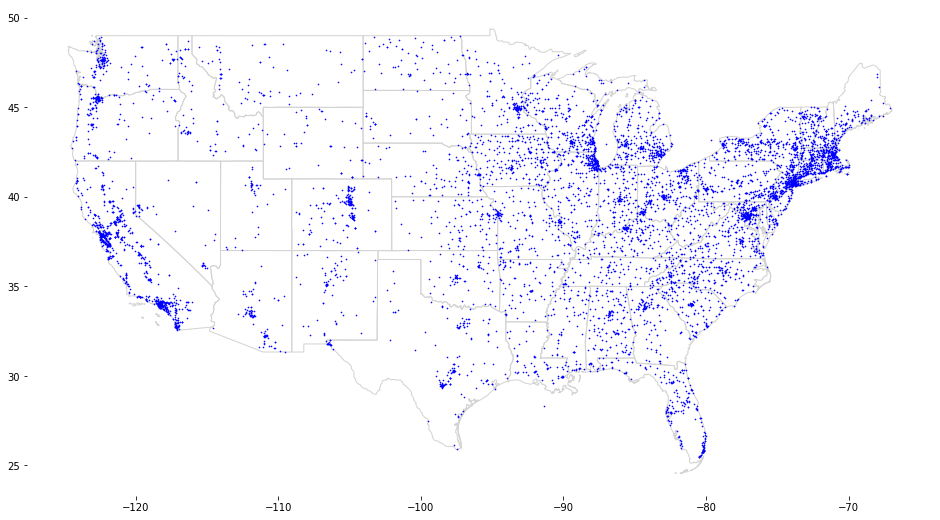

In [9]:
# Map again, this time with a more familiar projection
fig, ax = plt.subplots(figsize=(18,9))

conus.to_crs('epsg:4326').plot(
    ax=ax,
    color='none', 
    edgecolor='lightgrey'
)

mkt_loc_gdf.set_crs('epsg:4326').plot(
    ax=ax,
    markersize=0.4,
    color="blue"
)

plt.box(on=None) 

Now consider only the farmers’ markets in Colorado, Utah, New Mexico, and Arizona. There are 353 farmers' markets in these four states. (One is mislabeled, and is actually in Pennsylvania. Knock this out.)  The four-corner states help to illustrate the idea of using a state boundary as a natural experiment.

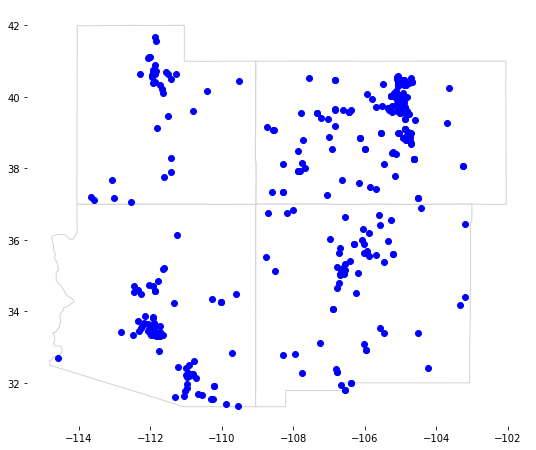

In [10]:
# create a geodataframe for the markets and state boundaries, limited to four states
fc_list = ["New Mexico", "Arizona", "Utah", "Colorado"]
fc = conus[conus.NAME.isin(fc_list)]
fc_mkts = mkt_loc_gdf[mkt_loc_gdf.State.isin(fc_list)]

# knock out another mislabeled market
fc_mkts = fc_mkts[fc_mkts.geometry.x < -90]

# plot the farmers markets in the four corner states
fig, ax = plt.subplots(figsize=(9,9))

fc.plot(
    ax=ax,
    color='white', 
    edgecolor='lightgrey'
)

fc_mkts.plot(
    ax=ax,
    color="blue"
)

plt.box(on=None) 

Now we can begin to try to make sense of the farmers' markets based on their characteristics.  In order to start to cluster the data, or to reduce the dimension of the data, we need to convert it into a matrix-like object, `X`:

In [11]:
X = df.iloc[:, 7:]
X = (X == "Y").astype(int)
X

,Credit,WIC,WICcash,SFMNP,SNAP,Bakedgoods,Cheese,Crafts,Flowers,Eggs,...,Maple,Meat,Nursery,Nuts,Plants,Poultry,Prepared,Soap,Trees,Wine
0,1,0,0,0,0,1,1,0,1,1,...,0,0,0,0,0,0,1,1,0,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,0,0
3,0,0,1,1,1,1,0,1,1,0,...,0,0,0,1,0,0,1,1,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7861,1,0,0,0,0,1,1,0,1,1,...,0,0,1,1,1,0,1,1,0,0
7862,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7863,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7864,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
# keep only the rows with FMIDs in the four-corner dataframe
fc_df = fc_mkts.merge(df, how="left", on=["FMID", "x", "y", "State"])

# deal with repeated columns
X = fc_df.iloc[:, 8:]

# convert it to binary, using a characteristic of pandas and booleans
X = (X == "Y").astype(int)

# create a list of lists to represent the dataframe
Xlist = X.values.tolist()

Are there certain characteristics, or combinations of characteristics, that allow a computer to predict the market's state without even knowing where the farmers' market is located? There are many, many ways to cluster markets.  Consider one with a nice visual representation, called a [dendrogram](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.dendrogram.html), part of the Scientific Python, `scipy`, library.

(0.0, 3530.0, 0.0, 42.43932290827053)

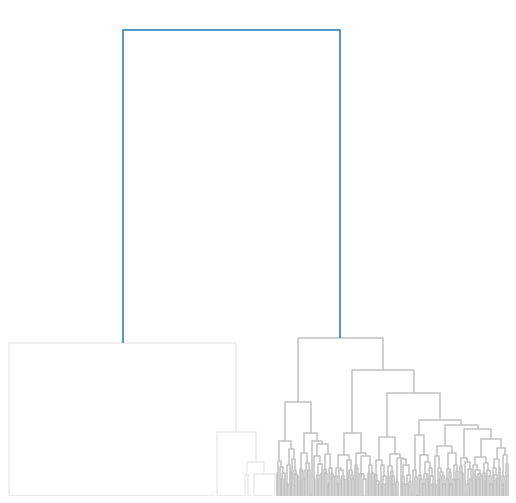

In [21]:
import scipy.cluster.hierarchy as shc
fig, ax = plt.subplots(figsize=(9,9))

# set a color palette based on hex color codes, repeating triplets
# NOTE: this sets a global variable, so try it first without applying these 
# colors so you can see how ugly it is
shc.set_link_color_palette(["#EAEAEA", "#C1C1C1", "#8E8E8E"])

# The distance metric between clusters `complete` is defined by the furthest 
# points between two clusters. Another way to calculate the distance leverates 
# the Ward method. Others worth exploring are: median, average.
dend = shc.dendrogram(
    shc.linkage(X, method="ward"),
    ax=ax
)

plt.box(on=None) 
plt.axis('off')

Choose the number of clusters by examining the dendrogram, looking for a minimum number of clusters that would give a reasonable representation of the full dataset.  There is no right answer.  Just some useful ones for teaching.  Without going too far into it, we use the scikit-learn `sklearn` library in Python.

In [22]:
from sklearn.cluster import AgglomerativeClustering

# the distance between points is given by `euclidean` while the clusters 
# are defined by minimizing variance using the Ward method.
cluster = AgglomerativeClustering(
    n_clusters=5, 
    affinity='euclidean', 
    linkage='ward'
)

# assign a new column based on the label and print the values in the new column
fc_df["label"] = cluster.fit_predict(Xlist)

# what are the different labels?
set(fc_df.label)

{0, 1, 2, 3, 4}

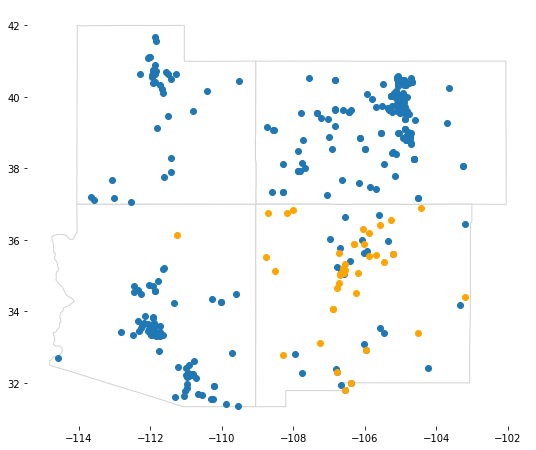

In [15]:
# plot the labels, incrementally, on a map to figure out if there is a geographic
# pattern associated with it.
fig, ax = plt.subplots(figsize=(9,9))

fc.plot(
    ax=ax,
    color='white', 
    edgecolor='lightgrey'
)

l = 1

# cycle through the labels,
# note that the label "1" seems to reflect farmers' markets in New Mexico
fc_df[fc_df.label != l].plot(
    ax=ax
)

# plot the New Mexico farmers' markets
fc_df[fc_df.label == l].plot(
    ax=ax,
    color="orange"
)

plt.box(on=None) 

It seems pretty apparent that there is something about farmers' markets in New Mexico that are unique to New Mexico, at least relative to the other three states in this small natural lab.  We can quantify this observation, or at least illustrate it quantitatively, through simulations.  For this, we will illustrate the sensitivity of this model, compared against purely random assignment of the `1` label.

In [16]:
# keep only those fields that are relevant to test sensitivity/specificity
# https://en.wikipedia.org/wiki/Sensitivity_and_specificity
tdf = fc_df[["State", "label"]]

# number of farmers' markets with predicted label `1`
tdf["label"] = (tdf["label"] == 1).astype(int)
print(sum(tdf.label))

# number of farmers' markets in New Mexico
tdf["newmex"] = (tdf["State"] == "New Mexico").astype(int)
print(sum(tdf.newmex))

# sensitivity is the true positive rate, observed.  True positives over all markets 
# in new mexico, including the false negatives (the markets in new mexico that were 
# not labeled).  Note that this is just one way to define a `true positive`.
sum(tdf.newmex * tdf.label)/sum(tdf.newmex)

43
69


0.6086956521739131

In [23]:
from numpy.random import permutation

# shuffle the label values
print(permutation(tdf.label.values))

def calc_shuffled_sensitivity(_df):
    # Calculate the true positive rate true positive rate on a shuffled
    true_pos = sum(_df.newmex * permutation(_df.label.values))
    return true_pos/sum(_df.newmex)

# sample sensitivy calcuation from a single permuatation of labels
# It will give a different value each time you run it, based on the shuffling
print(calc_shuffled_sensitivity(tdf))

[0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0
 0 0 1 0 0 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 0 0]
0.08695652173913043


In [24]:
# Collect the results.  You can, and maybe more easy to understand, 
# do this in a for-loop
res = [calc_sensitivity(tdf) for b in range(100000)]

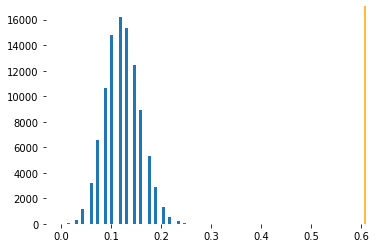

In [25]:
# plot the results from the simulation with the observed sensitivi
plt.hist(res, bins=50)
plt.axvline(sum(tdf.newmex * tdf.label)/sum(tdf.newmex), color="orange")
plt.box(on=None)